In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt

import glob
from glob import glob
import nibabel as nb

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
torch.cuda.memory_allocated()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

0

In [5]:
from dataclasses import dataclass

@dataclass
class Parameters:
    bs : int
    n_channels : int
    ngf : int
    ndf : int
    size : int
    gen_n_down : int
    gen_n_blocks : int
    dis_n_down : int

p = Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2)

In [6]:
bs = 1
workers = 2
image_size = (64,64)
dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\mri2sos_dataset'
datasets_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))

from torch.utils import data
idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['B']]
mri_subset = data.Subset(datasets_train, idx)
dataloader_mri = torch.utils.data.DataLoader(mri_subset, batch_size=bs,
                                         shuffle=True, num_workers=workers)
idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['A']]
sos_subset = data.Subset(datasets_train, idx)

dataloader_sos = torch.utils.data.DataLoader(sos_subset, batch_size=bs,
                                         shuffle=True, num_workers=workers)

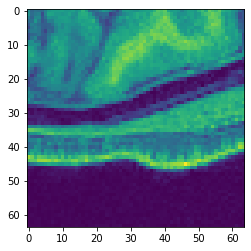

In [5]:
plt.imshow(next(iter(dataloader_mri))[0][0,0,:,:])

In [22]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):

  torch.save(G_A2B, name+"_G_A2B.pt")
  torch.save(G_B2A,  name+"_G_B2A.pt")
  torch.save(D_A,  name+"_D_A.pt")
  torch.save(D_B, name+"_D_B.pt")

def load_models( name):
  G_A2B=torch.load(name+'_G_A2B.pt', map_location=torch.device('cpu'))
  G_B2A=torch.load(name+"_G_B2A.pt",map_location=torch.device('cpu'))
  D_A=torch.load(name+"_D_A.pt", map_location=torch.device('cpu'))
  D_B=torch.load(name+"_D_B.pt", map_location=torch.device('cpu'))
  return G_A2B, G_B2A, D_A, D_B

In [8]:
from ResnetGenerator import ResnetGenerator
from NLayerDiscriminator import NLayerDiscriminator

In [9]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

In [36]:
G_A2B = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, padding_type='reflect').to(device)
G_B2A = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, padding_type='reflect').to(device)
D_A = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.n_channels, norm_layer=nn.BatchNorm2d).to(device)
D_B = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.n_channels, norm_layer=nn.BatchNorm2d).to(device)
name = "try5"
# G_A2B, G_B2A, D_A, D_B= load_models(name)
# G_A2B.to(device)
# G_B2A.to(device)
# D_A.to(device)
# D_B.to(device)

# Initialize Loss function
criterion_Im = torch.nn.L1Loss() 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [34]:
def plot_images_test(dataloader_mri, dataloader_sos): 
    batch_a_test = next(iter(dataloader_mri))[0][:,0,:,:].unsqueeze(1).to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test).cpu().detach()

    plt.figure(figsize=(2,2))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real MRIs")
    plt.show()

          
    plt.figure(figsize=(2,2))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake SoS images")
    plt.show()


    batch_b_test = next(iter(dataloader_sos))[0][:,0,:,:].unsqueeze(1).to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    
    plt.figure(figsize=(2,2))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real SoS images")
    plt.show()

    plt.figure(figsize=(2,2))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake MRIs")
    plt.show()

def plot_all_images(image_number, dataloader_mri, dataloader_zebra_test): 
    #generate fake zebras
    batch_a_test = next(iter(dataloader_mri))[0][0,0,:,:].unsqueeze(1).to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real MRIs")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake SoS")
    plt.show()
    #generate fake horses
    batch_b_test = next(iter(dataloader_zebra_test))[0][0,0,:,:].unsqueeze(1).to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real SoS")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake MRIs")
    plt.show()
    #identity 
    # identity_a_test=G_B2A(batch_a_test.cuda() ).cpu().detach()
    # identity_b_test=G_A2B(batch_b_test.cuda() ).cpu().detach()
    # plt.figure(figsize=(10,10))
    # plt.imshow(np.transpose(vutils.make_grid((identity_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    # plt.axis("off")
    # plt.title("Identity MRIs")
    # plt.show()
    # plt.figure(figsize=(10,10))
    # plt.imshow(np.transpose(vutils.make_grid((identity_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    # plt.axis("off")
    # plt.title("Identity SoS")
    # plt.show()
    #recovered image
    recover_a_test=G_B2A(fake_b_test.cuda()  ).cpu().detach()
    recover_b_test=G_A2B(fake_a_test.cuda()  ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered MRIs")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered SoS")
    plt.show()

In [37]:
def training(G_A2B, G_B2A, D_A, D_B,num_epochs,name,old = True):

  print(wandb.config)  

  # Training Loop

  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_A_losses = []
  D_B_losses = []


  iters=0
  FDL_A2B = []
  FDL_B2A = []
  CL_A = []
  CL_B = []
  ID_B2A = []
  ID_A2B = []
  disc_A = []
  disc_B = []


  FDL_A2B_t = []
  FDL_B2A_t = []
  CL_A_t = []
  CL_B_t = []
  ID_B2A_t = []
  ID_A2B_t = []
  disc_A_t = []
  disc_B_t = []

  print("Starting Training Loop...")
  # For each epoch
  for epoch in range(num_epochs):

    # For each batch in the dataloader
    for i,(data_mri, data_sos) in enumerate(zip(dataloader_mri, dataloader_sos),0):
        # print(b)
        # Set model input
        a_real = data_mri[0][:,0,:,:].unsqueeze(1).to(device)
        b_real = data_sos[0][:,0,:,:].unsqueeze(1).to(device)
      
        # tensor_ones=torch.ones([a_real.shape[0],1,14,14]).to(device)
        # tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).to(device)

        # Generated images
        # print("a_real shape: "+str(a_real.shape))
        b_fake = G_A2B(a_real)
        # print("fake image generated")
        a_rec = G_B2A(b_fake)
        a_fake = G_B2A(b_real)
        b_rec = G_A2B(a_fake)

        # CALCULATE DISCRIMINATORS LOSSES
        # Discriminator A
        optimizer_D_A.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(1, old_a_fake.shape[0]-1)
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
          D_A_losses.append(Disc_loss_A.item())

        else:
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
          D_A_losses.append(Disc_loss_A.item())

        # Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
        # D_A_losses.append(Disc_loss_A.item())
        
        Disc_loss_A.backward()
        optimizer_D_A.step()

        
        # Discriminator B

        optimizer_D_B.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(1, old_b_fake.shape[0]-1)
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
          D_B_losses.append(Disc_loss_B.item())
        else:
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
          D_B_losses.append(Disc_loss_B.item())

        Disc_loss_B.backward()
        optimizer_D_B.step()   

        # Generator

        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()


        # CALCULATE GENERATORS LOSSES
        Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
        Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

        # Cycle Consistency    both use the two generators
        Cycle_loss_A = criterion_Im(a_rec, a_real)*5
        Cycle_loss_B = criterion_Im(b_rec, b_real)*5

        # Identity loss
        Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
        Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

        # generator losses
        Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        G_losses.append(Loss_G)

        wandb.log({
            "disc_loss_A2B": Fool_disc_loss_A2B,
            "disc_loss_B2A": Fool_disc_loss_B2A,
            "Cycle_loss_A": Cycle_loss_A,
            "Cycle_loss_B": Cycle_loss_B,
            "id_loss_A2B": Id_loss_A2B,
            "id_loss_B2A": Id_loss_B2A,
            "total_g": Loss_G,
            "total_d": Fool_disc_loss_A2B + Fool_disc_loss_B2A
        })

        # Backward propagation
        Loss_G.backward()
        
        
        # Optimisation step
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()

        FDL_A2B.append(Fool_disc_loss_A2B)
        FDL_B2A.append(Fool_disc_loss_B2A)
        CL_A.append(Cycle_loss_A)
        CL_B.append(Cycle_loss_B)
        ID_B2A.append(Id_loss_B2A)
        ID_A2B.append(Id_loss_A2B)
        disc_A.append(Disc_loss_A)
        disc_B.append(Disc_loss_B)

        if(iters == 0 and epoch == 0):
          old_b_fake = b_fake.clone()
          old_a_fake = a_fake.clone()
        elif (old_b_fake.shape[0] == p.bs*5 and b_fake.shape[0]==p.bs):
          rand_int = random.randint(5, 24)
          old_b_fake[rand_int-5:rand_int] = b_fake.clone()
          old_a_fake[rand_int-5:rand_int] = a_fake.clone()
        elif(old_b_fake.shape[0]< 25):
          old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
          old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

        iters += 1
        del a_real, b_real, a_fake, b_fake


        if iters % 50 == 0:
      
          print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
          # print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
          #             % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B, Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    save_models(G_A2B, G_B2A, D_A, D_B, name)
    if (epoch % 5 == 0):
      plot_images_test(dataloader_mri, dataloader_sos)
    # plot_all_images(4, dataloader_vangogh, dataloader_photo)
  return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

In [38]:
# !pip install wandb
import wandb
wandb.init(project="mri2sos-patches", entity="clara_rg_")

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [13]:
wandb.config = {
    "learning_rate": lr,
    "epochs": 20,
    "betas": (beta1, 0.999),
    "G_A2B_params": G_A2B.parameters(),
    "G_B2A_params": G_B2A.parameters(),
    "D_A_params": D_A.parameters(),
    "D_B_params": D_B.parameters(),
    "params": p,
    "name" : name
}

{}
Starting Training Loop...
[1/20]	FDL_A2B: 0.3343	FDL_B2A: 0.2793	CL_A: 0.6796	CL_B: 0.4567	ID_B2A: 0.9676	ID_A2B: 0.8732	Loss_D_A: 0.4921	Loss_D_A: 0.4650
[1/20]	FDL_A2B: 0.6883	FDL_B2A: 0.3526	CL_A: 0.5353	CL_B: 0.5118	ID_B2A: 1.1271	ID_A2B: 0.2579	Loss_D_A: 0.4897	Loss_D_A: 0.2571
[1/20]	FDL_A2B: 0.4343	FDL_B2A: 0.3118	CL_A: 0.7835	CL_B: 0.4199	ID_B2A: 1.7451	ID_A2B: 0.3648	Loss_D_A: 0.4793	Loss_D_A: 0.2736
[1/20]	FDL_A2B: 0.7618	FDL_B2A: 0.4878	CL_A: 0.7255	CL_B: 0.2943	ID_B2A: 1.3893	ID_A2B: 0.2191	Loss_D_A: 0.3414	Loss_D_A: 0.1599
[1/20]	FDL_A2B: 0.4490	FDL_B2A: 0.2589	CL_A: 0.4905	CL_B: 3.4148	ID_B2A: 0.8802	ID_A2B: 6.2445	Loss_D_A: 0.3228	Loss_D_A: 0.5416
[1/20]	FDL_A2B: 0.4762	FDL_B2A: 0.2084	CL_A: 0.4458	CL_B: 1.3222	ID_B2A: 0.7330	ID_A2B: 0.4939	Loss_D_A: 0.7341	Loss_D_A: 0.2669
[1/20]	FDL_A2B: 0.5073	FDL_B2A: 0.4359	CL_A: 0.6557	CL_B: 0.5151	ID_B2A: 0.9983	ID_A2B: 0.6965	Loss_D_A: 0.2694	Loss_D_A: 0.3922
[1/20]	FDL_A2B: 0.6245	FDL_B2A: 0.5944	CL_A: 0.7226	CL_B: 0.3221	ID_

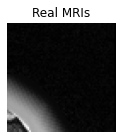

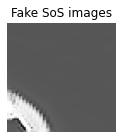

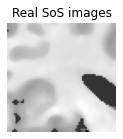

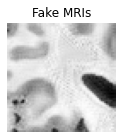

[2/20]	FDL_A2B: 0.5543	FDL_B2A: 0.3958	CL_A: 0.2897	CL_B: 0.3318	ID_B2A: 0.3213	ID_A2B: 0.3361	Loss_D_A: 0.3429	Loss_D_A: 0.5501
[2/20]	FDL_A2B: 0.2362	FDL_B2A: 0.5791	CL_A: 0.2071	CL_B: 0.1286	ID_B2A: 0.2101	ID_A2B: 0.2406	Loss_D_A: 0.4865	Loss_D_A: 0.2198
[2/20]	FDL_A2B: 0.4170	FDL_B2A: 0.3373	CL_A: 0.8112	CL_B: 0.4221	ID_B2A: 0.4287	ID_A2B: 0.7692	Loss_D_A: 0.5170	Loss_D_A: 0.2601
[2/20]	FDL_A2B: 0.6589	FDL_B2A: 0.2445	CL_A: 0.3069	CL_B: 0.0928	ID_B2A: 0.4428	ID_A2B: 0.0889	Loss_D_A: 0.5025	Loss_D_A: 0.0826
[2/20]	FDL_A2B: 0.2598	FDL_B2A: 0.4863	CL_A: 0.1698	CL_B: 0.2143	ID_B2A: 0.2170	ID_A2B: 0.3065	Loss_D_A: 0.5533	Loss_D_A: 0.3655
[2/20]	FDL_A2B: 0.6283	FDL_B2A: 0.4395	CL_A: 0.3862	CL_B: 0.0681	ID_B2A: 0.6711	ID_A2B: 0.0941	Loss_D_A: 0.3021	Loss_D_A: 0.1088
[2/20]	FDL_A2B: 0.7188	FDL_B2A: 0.5949	CL_A: 0.2895	CL_B: 0.2165	ID_B2A: 0.3824	ID_A2B: 0.4142	Loss_D_A: 0.1824	Loss_D_A: 0.1544
[2/20]	FDL_A2B: 0.3848	FDL_B2A: 0.2242	CL_A: 0.3029	CL_B: 0.4125	ID_B2A: 0.6489	ID_A2B: 0.7099	Lo

In [39]:
epochs=20
netG_A2B, netG_B2A, netD_A, netD_B=G_A2B, G_B2A, D_A, D_B

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

losses = training( netG_A2B, netG_B2A, netD_A, netD_B,epochs,name)

In [25]:
test_mris = []
test_soss = []
ns = []
count = 0
while count < 50:
    n = random.randint(0,7198)
    if(n not in ns):
        test_mris.append(plt.imread(r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\mri2sos_dataset\A\mri_img'+str(n)+'.png'))
        test_soss.append(plt.imread(r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\mri2sos_dataset\B\sos_img'+str(n)+'.png'))
        ns.append(n)
        count += 1
print(len(test_mris))

50


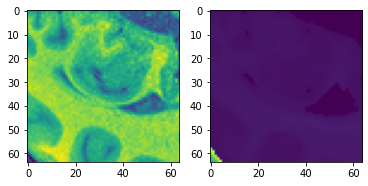

In [8]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(test_mris[13])
plt.subplot(1,2,2)
plt.imshow(test_soss[13])

In [29]:
test_fake_mris = []
test_fake_soss = []
for i in range(len(test_mris)):
    a = torch.Tensor(test_mris[i]).unsqueeze(0).unsqueeze(0)
    test_fake_soss.append(G_A2B(a.to(device)).cpu().detach().numpy())
    b = torch.Tensor(test_soss[i]).unsqueeze(0).unsqueeze(0)
    test_fake_mris.append(G_B2A(b.to(device)).cpu().detach().numpy())
    # print('After adding:' + str(torch.cuda.memory_allocated()))
    a.detach().cpu()
    with torch.no_grad():
        b.detach().cpu()
    # print('After deleting:' + str(torch.cuda.memory_allocated()))

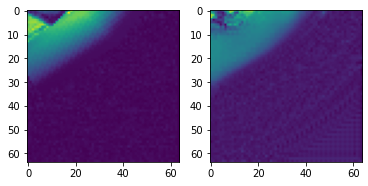

In [44]:
n = 9
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(test_mris[n])
plt.subplot(1,2,2)
plt.imshow(test_fake_mris[n][0,0,:,:])

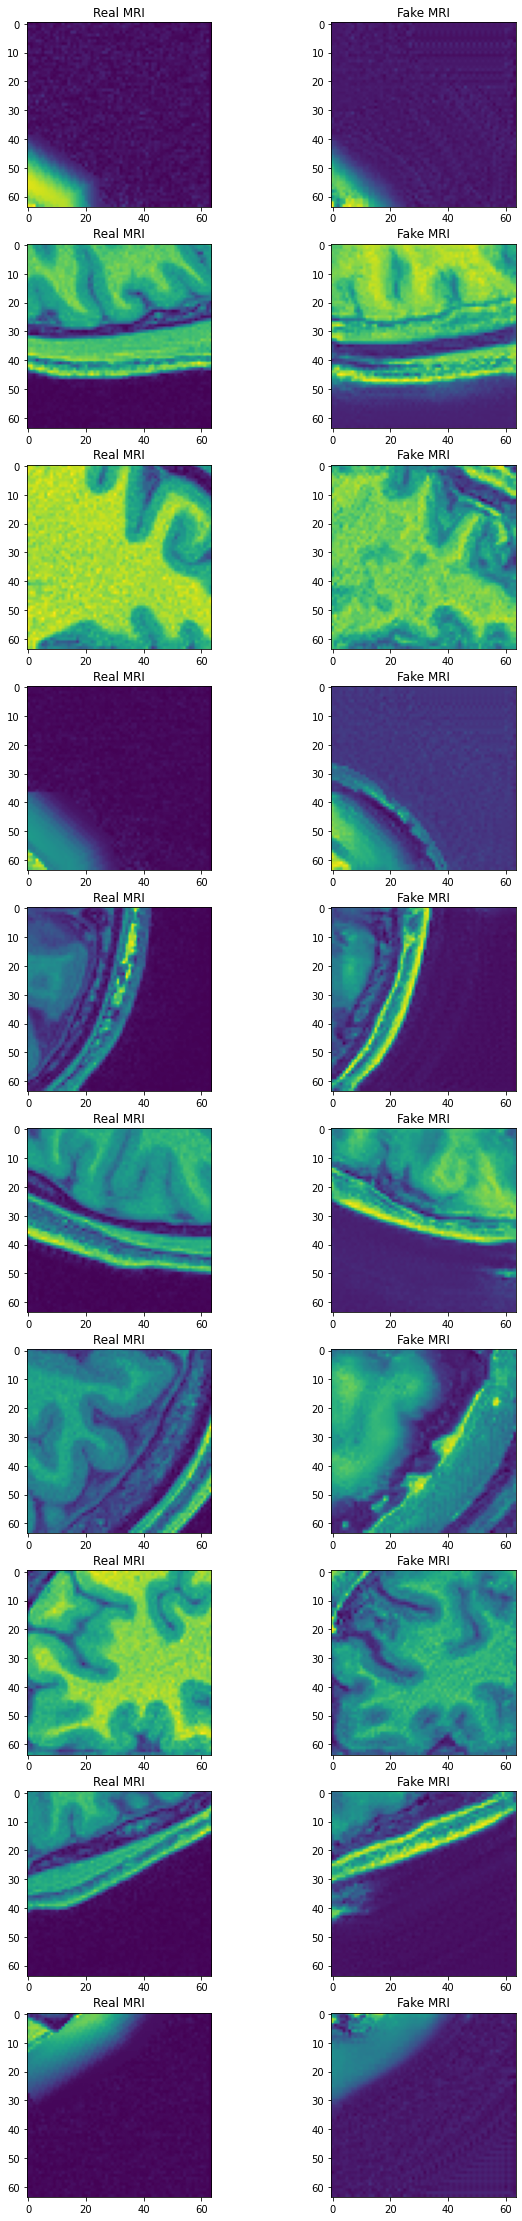

In [55]:
plt.subplots(10,2, figsize=(10,40))
count = 0
for i in range(1,21):
    plt.subplot(10,2,i)
    if (i%2):
        plt.imshow(test_mris[count])
        plt.title('Real MRI')
    else:
        plt.imshow(test_fake_mris[count][0,0,:,:])
        plt.title('Fake MRI')
        count += 1

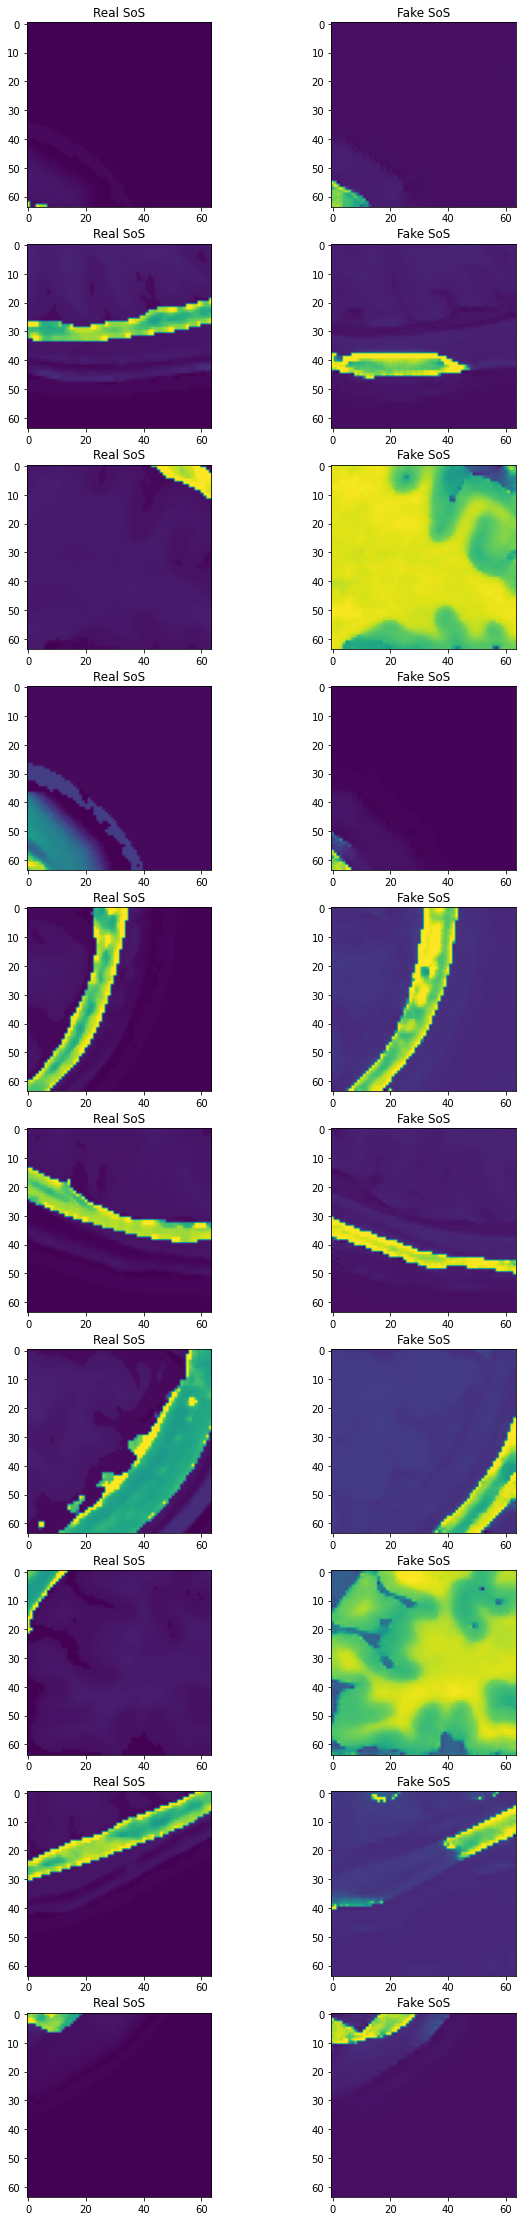

In [57]:
plt.subplots(10,2, figsize=(10,40))
count = 0
for i in range(1,21):
    plt.subplot(10,2,i)
    if (i%2):
        plt.imshow(test_soss[count])
        plt.title('Real SoS')
    else:
        plt.imshow(test_fake_soss[count][0,0,:,:])
        plt.title('Fake SoS')
        count += 1

# Evaluation

In [78]:
def average(lst):
    return sum(lst) / len(lst)

1. MSE

In [60]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

#https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/

In [73]:
mri_mses = []
sos_mses = []
for i in range(len(test_mris)):
    # error in fake MRIs
    mri_mses.append(mse(test_mris[i], test_fake_mris[i][0,0,:,:]))

    # error in fake SoS images
    sos_mses.append(mse(test_soss[i], test_fake_soss[i][0,0,:,:]))

Average MSE for MRIs: 0.05027305982447476
Average MSE for SoS images: 0.17491568619730347


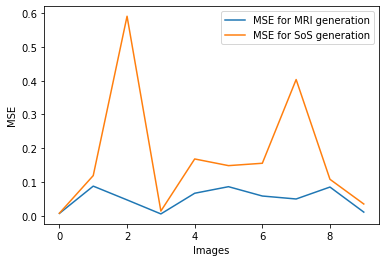

In [79]:
plt.plot([x for x in range(len(test_mris))], mri_mses);
plt.plot([x for x in range(len(test_mris))], sos_mses);
plt.legend(['MSE for MRI generation', 'MSE for SoS generation']);
plt.ylabel('MSE');
plt.xlabel('Images');
print("Average MSE for MRIs: "+str(average(mri_mses)))
print("Average MSE for SoS images: "+str(average(sos_mses)))

2. SSIM

In [75]:
from skimage.metrics import structural_similarity as ssim
mri_ssim = []
sos_ssim = []
for i in range(len(test_mris)):
    mri_ssim.append(ssim(test_mris[i], test_fake_mris[i][0,0,:,:]))
    sos_ssim.append(ssim(test_soss[i], test_fake_soss[i][0,0,:,:]))

Average SSIM for MRIs: 0.4937587894346409
Average SSIM for SoS images: 0.5151313624433128


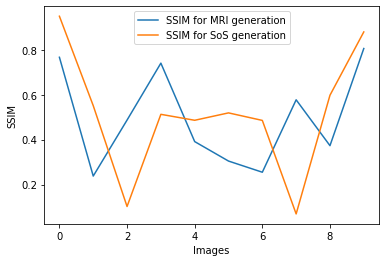

In [81]:
plt.plot([x for x in range(len(test_mris))], mri_ssim);
plt.plot([x for x in range(len(test_mris))], sos_ssim);
plt.legend(['SSIM for MRI generation', 'SSIM for SoS generation']);
plt.ylabel('SSIM');
plt.xlabel('Images');
print("Average SSIM for MRIs: "+ str(average(mri_ssim)));
print("Average SSIM for SoS images: "+str(average(sos_ssim)))

3. PSNR

In [83]:
def PSNR(image1, image2):
    mse = np.mean((image1 - image2) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [84]:
mri_psnr = []
sos_psnr = []
for i in range(len(test_mris)):
    mri_psnr.append(PSNR(test_mris[i], test_fake_mris[i][0,0,:,:]))
    sos_psnr.append(PSNR(test_soss[i], test_fake_soss[i][0,0,:,:]))

Average PSNR for MRIs: 62.77941198248548
Average PSNR for SoS images: 58.50547658216111


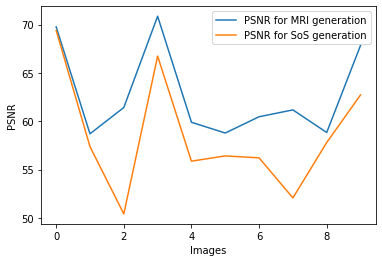

In [85]:
plt.plot([x for x in range(len(test_mris))], mri_psnr);
plt.plot([x for x in range(len(test_mris))], sos_psnr);
plt.legend(['PSNR for MRI generation', 'PSNR for SoS generation']);
plt.ylabel('PSNR');
plt.xlabel('Images');
print("Average PSNR for MRIs: "+ str(average(mri_psnr)));
print("Average PSNR for SoS images: "+str(average(sos_psnr)))

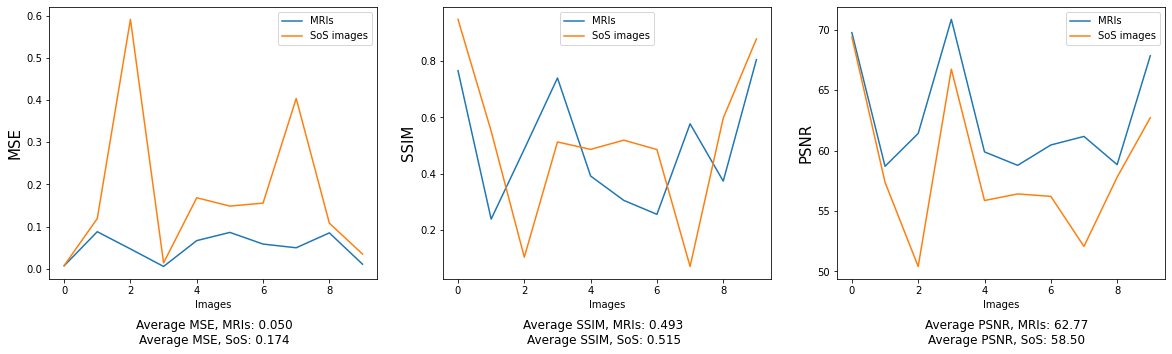

In [113]:
plt.subplots(1,3, figsize=(20,5))
plt.subplot(1,3,1)
plt.plot([x for x in range(len(test_mris))], mri_mses);
plt.plot([x for x in range(len(test_mris))], sos_mses);
plt.legend(['MRIs', 'SoS images']);
plt.ylabel('MSE', fontsize=15);
plt.xlabel('Images');
txt = "Average MSE, MRIs: "+str(average(mri_mses))[0:5] + "\nAverage MSE, SoS: "+str(average(sos_mses))[0:5];
plt.figtext(0.24, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12);

plt.subplot(1,3,2)
plt.plot([x for x in range(len(test_mris))], mri_ssim);
plt.plot([x for x in range(len(test_mris))], sos_ssim);
plt.legend(['MRIs', 'SoS images'], loc='upper center');
plt.ylabel('SSIM', fontsize=15);
plt.xlabel('Images');
txt = "Average SSIM, MRIs: "+ str(average(mri_ssim))[0:5] + "\nAverage SSIM, SoS: "+str(average(sos_ssim))[0:5];
plt.figtext(0.51, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12);

plt.subplot(1,3,3)
plt.plot([x for x in range(len(test_mris))], mri_psnr);
plt.plot([x for x in range(len(test_mris))], sos_psnr);
plt.legend(['MRIs', 'SoS images']);
plt.ylabel('PSNR', fontsize=15);
plt.xlabel('Images');
txt = "Average PSNR, MRIs: "+ str(average(mri_psnr))[0:5] + "\nAverage PSNR, SoS: "+str(average(sos_psnr))[0:5];
plt.figtext(0.79, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12);
